# Rasterising vectors & vectorising rasters

* **Products used:** 
[wofs_ls_summary_annual](https://explorer.digitalearth.africa/wofs_ls_summary_annual)

## Background

Many remote sensing and/or geospatial workflows require converting between vector data (e.g. shapefiles) and raster data (e.g. pixel-based data like that in an `xarray.DataArray`).
For example, we may need to use a shapefile as a mask to limit the analysis extent of a raster, or have raster data that we want to convert into vector data to allow for easy geometry operations.

## Description
In this notebook, we show how to use the Digital Earth Africa function `xr_rasterize` and `xr_vectorize` in [deafrica_tools.spatial](../Tools/deafrica_tools/spatial.py). The notebook demonstrates how to:

1. Load in data from the [Water Observations from Space (WOfS)](https://docs.digitalearthafrica.org/en/latest/data_specs/Landsat_WOfS_specs.html) product
2. Vectorise the pixel-based `xarray.DataArray` WOfS object into a vector-based `geopandas.GeoDataFrame` object containing persistent water-bodies as polygons
3. Export the `geopandas.GeoDataFrame` as a shapefile
4. Rasterise the `geopandas.GeoDataFrame` vector data back into an `xarray.DataArray` object and export the results as a GeoTIFF

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages


In [1]:
%matplotlib inline

import datacube
import geopandas as gpd
from odc.geo.geom import Geometry

from deafrica_tools.datahandling import mostcommon_crs
from deafrica_tools.spatial import xr_vectorize, xr_rasterize
from deafrica_tools.areaofinterest import define_area

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app='Rasterise_vectorise')

## Load WOfS data from the datacube

We will load in an annual summary from the Water Observations from Space (WOfS) product to provide us with some data to work with.

#### Select location
To define the area of interest, there are two methods available:

1. By specifying the latitude, longitude, and buffer. This method requires you to input the central latitude, central longitude, and the buffer value in square degrees around the center point you want to analyze. For example, `lat = 10.338`, `lon = -1.055`, and `buffer = 0.1` will select an area with a radius of 0.1 square degrees around the point with coordinates (10.338, -1.055).

2. By uploading a polygon as a `GeoJSON or Esri Shapefile`. If you choose this option, you will need to upload the geojson or ESRI shapefile into the Sandbox using Upload Files button <img align="top" src="../Supplementary_data/upload_files_icon.png"> in the top left corner of the Jupyter Notebook interface. ESRI shapefiles must be uploaded with all the related files `(.cpg, .dbf, .shp, .shx)`. Once uploaded, you can use the shapefile or geojson to define the area of interest. Remember to update the code to call the file you have uploaded.

To use one of these methods, you can uncomment the relevant line of code and comment out the other one. To comment out a line, add the `"#"` symbol before the code you want to comment out. By default, the first option which defines the location using latitude, longitude, and buffer is being used.

In [3]:
# Select a location
# Method 1: Specify the latitude, longitude, and buffer
aoi = define_area(lat=13.50, lon=-15.42, buffer=0.2)

# Method 2: Use a polygon as a GeoJSON or Esri Shapefile. 
# aoi = define_area(vector_path='aoi.shp')

#Create a geopolygon and geodataframe of the area of interest
geopolygon = Geometry(aoi["features"][0]["geometry"], crs="epsg:4326")
geopolygon_gdf = gpd.GeoDataFrame(geometry=[geopolygon], crs=geopolygon.crs)

# Get the latitude and longitude range of the geopolygon
lat_range = (geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[3])
lon_range = (geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[2])

# Create a reusable query
query = {
    'x': lon_range,
    'y': lat_range,
    'time': ('2017')
}
# Identify the most common projection system in the input query
output_crs = mostcommon_crs(dc=dc, product='ls8_sr', query=query)

# Load WoFS through the datacube
ds = dc.load(product='wofs_ls_summary_annual', 
             output_crs=output_crs,
             align=(15, 15),
             resolution=(-30, 30),
             **query)

print(ds)


<xarray.Dataset> Size: 17MB
Dimensions:      (time: 1, y: 1478, x: 1447)
Coordinates:
  * time         (time) datetime64[ns] 8B 2017-07-02T11:59:59.999999
  * y            (y) float64 12kB 1.515e+06 1.515e+06 ... 1.47e+06 1.47e+06
  * x            (x) float64 12kB 4.328e+05 4.329e+05 ... 4.762e+05 4.762e+05
    spatial_ref  int32 4B 32628
Data variables:
    count_wet    (time, y, x) int16 4MB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    count_clear  (time, y, x) int16 4MB 30 30 30 30 30 30 ... 26 26 26 26 26 26
    frequency    (time, y, x) float32 9MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    crs:           epsg:32628
    grid_mapping:  spatial_ref


### Plot the WOfS summary

Let's plot the WOfS data to get an idea of the objects we will be transforming. 
In the code below, we first select the pixels where the satellite has observed water at least 25% of the year, this is so we can isolate the more persistent water bodies and reduce some of the noise before we vectorise the raster.

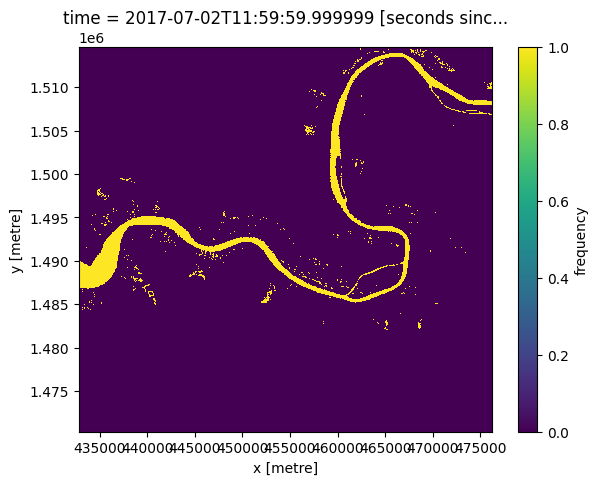

In [4]:
# Select pixels that are classified as water > 25 % of the year
water_bodies = ds.frequency > 0.25

# Plot the data
water_bodies.plot(size=5)

## Vectorising an `xarray.DataArray`

To convert our `xarray.DataArray` object into a vector based `geopandas geodataframe`, we can use the DE Africa function [`xr_vectorize`](https://docs.digitalearthafrica.org/en/latest/sandbox/notebooks/Tools/gen/deafrica_tools.spatial.html#deafrica_tools.spatial.xr_vectorize) in the [deafrica_tools.spatial](https://docs.digitalearthafrica.org/en/latest/sandbox/notebooks/Tools/gen/deafrica_tools.spatial.html) module. This tool is based on the [rasterio.features.shape](https://rasterio.readthedocs.io/en/stable/api/rasterio.features.html) function, and can accept any of the arguments in `rasterio.features.shape` using the same syntax.

In the cell below, we use the argument `mask=water_bodies.values==1` to indicate we only want to convert the values in the xarray object that are equal to 1.


> **Note**: Both `xr_rasterize` and `xr_vectorize` will attempt to automatically obtain the `crs` and `transform` from the input data, but if the data does not contain this information, you will need to manually provide this.  In the cell below, we will get the `crs` and `transform` from the original dataset.

In [5]:
gdf = xr_vectorize(water_bodies,
                   crs=ds.crs,
                   mask=water_bodies.values==1)

print(gdf.head())


   attribute                                           geometry
0        1.0  POLYGON ((462495 1514655, 462495 1514625, 4625...
1        1.0  POLYGON ((465945 1514655, 465945 1514625, 4659...
2        1.0  POLYGON ((466125 1514655, 466125 1514625, 4661...
3        1.0  POLYGON ((466275 1514655, 466275 1514625, 4663...
4        1.0  POLYGON ((462315 1514625, 462315 1514565, 4623...


### Plot our vectorised raster 

<Axes: >

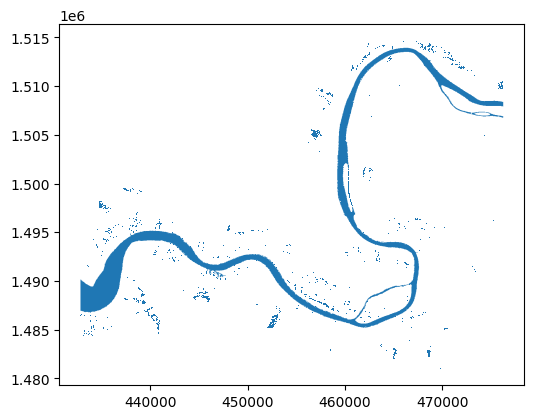

In [6]:
gdf.plot(figsize=(6, 6))

### Export as shapefile

Our function also allows us to very easily export the `GeoDataFrame` as a `shapefile` for use in other applications using the `export_shp` parameter.

In [7]:
gdf = xr_vectorize(da=water_bodies,
                   crs=ds.crs,
                   mask=water_bodies.values == 1.,
                   output_path='test.shp')

Exporting vector data to test.shp


## Rasterising a shapefile

Using the  [`xr_rasterize`](https://docs.digitalearthafrica.org/en/latest/sandbox/notebooks/Tools/gen/deafrica_tools.spatial.html#deafrica_tools.spatial.xr_rasterize) function in the [deafrica_tools.spatial](https://docs.digitalearthafrica.org/en/latest/sandbox/notebooks/Tools/gen/deafrica_tools.spatial.html) module (based on the rasterio function: [rasterio.features.rasterize](https://rasterio.readthedocs.io/en/stable/api/rasterio.features.html), and can accept any of the arguments in `rasterio.features.rasterize` using the same syntax) we can turn the `geopandas.GeoDataFrame` back into a `xarray.DataArray`.

As we already have the `GeoDataFrame` loaded we don't need to read in the shapefile, but if we wanted to read in a shapefile first we can use [gpd.read_file()](https://geopandas.org/en/stable/docs/reference/api/geopandas.read_file.html#geopandas.read_file).   

This function uses an `xarray.dataArray` object as a **template** for converting the `geodataframe` into a raster object (the template provides the `size`, `crs`, `dimensions`, `transform`, and `attributes` of the output array).

In [8]:
water_bodies_again = xr_rasterize(gdf=gdf,
                                  da=water_bodies,
                                  crs=ds.crs)

print(water_bodies_again)


<xarray.DataArray (y: 1478, x: 1447)> Size: 17MB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * y            (y) float64 12kB 1.515e+06 1.515e+06 ... 1.47e+06 1.47e+06
  * x            (x) float64 12kB 4.328e+05 4.329e+05 ... 4.762e+05 4.762e+05
    spatial_ref  int32 4B 32628


### Export as GeoTIFF

`xr_rasterize` also allows for exporting the results as a GeoTIFF using the parameter `export_tiff`.  To do this, a `named` array is required. If one is not provided, the functon wil provide a default one.

In [9]:
water_bodies_again = xr_rasterize(gdf=gdf,
                                  da=water_bodies,
                                  crs=ds.crs,
                                  output_path='test.tif')

Exporting raster data to test.tif


---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [10]:
print(datacube.__version__)

1.8.20


**Last Tested:**

In [11]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2025-01-15'